## AB testing conversion rates

In the previous screencast we showed how to estimate a single conversion rate using the Beta Binomial so that our uncertainty is displayed - my favourite way of saying this is uncertainity quantification. Let's see how we can extend this to AB testing. 

In [65]:
%pylab inline
figsize(20,10)

Populating the interactive namespace from numpy and matplotlib


In [68]:
from scipy.stats import beta

In [73]:
# Suppose we have the results of an A/B test: 
dataA = {
        "total":65410,
        "conversions":6554
}
dataB = {
            "total":65542,
            "conversions":6215
}

# Naively, we might say, well
print ("group A's observed rate: %.4f" %(dataA['conversions']/dataA['total']))
print ("group B's observed rate: %.4f" %(dataB['conversions']/dataB['total']))

group A's observed rate: 0.1002
group B's observed rate: 0.0948


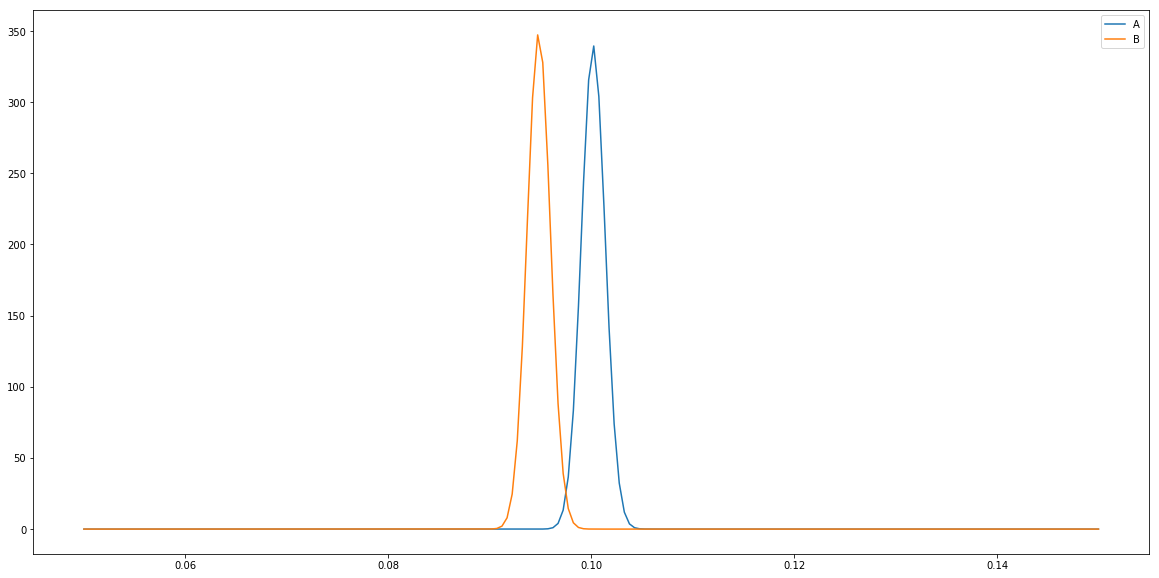

In [75]:
# Lets compare the posteriors of these though:

def plot_posteriors(x, data, label):
    #plot posterior of A
    y = beta.pdf(x, 1 + data['conversions'], 1 + data['total'] - data['conversions'])
    plt.plot(x,y,label=label)
    plt.legend()
    return


x = np.linspace(0.05,0.15,200)

plot_posteriors(x, dataA, 'A')
plot_posteriors(x, dataB, 'B')

In [76]:
# Although the observed rate of B is higher, it is possible that A's might indeed be
# higher. For example, the true value of A might be in the right tail, and the true
# value of B might be in the left tail. That's an interesting idea, how often 
# does that occur? That is, how often does the value of A fall above the value of B?

def sample_posteriors(dataA,dataB):
    
    samplesA = beta.rvs(1 + dataA['conversions'], 
                        1 + dataA['total'] - dataA['conversions'], size=1000000)
    
    samplesB = beta.rvs(1 + dataB['conversions'], 
                        1 + dataB['total'] - dataB['conversions'], size=1000000)
    return samplesA, samplesB

samplesA, samplesB = sample_posteriors(dataA,dataB)

In [77]:
(samplesA > samplesB).mean()

0.999464

In [78]:
(samplesA < samplesB).mean()

0.000536

That means that the $P(B > A \;\; |\; \text{data}) = 0.77$. Given the current observations, you can decide that group B has a higher conversion rate than A, but there is 1-0.77 = 0.23 probability you are wrong. This is still a pretty high probability of failure.  Let's look at some more: 

group A's observed rate: 0.100
group B's observed rate: 0.095


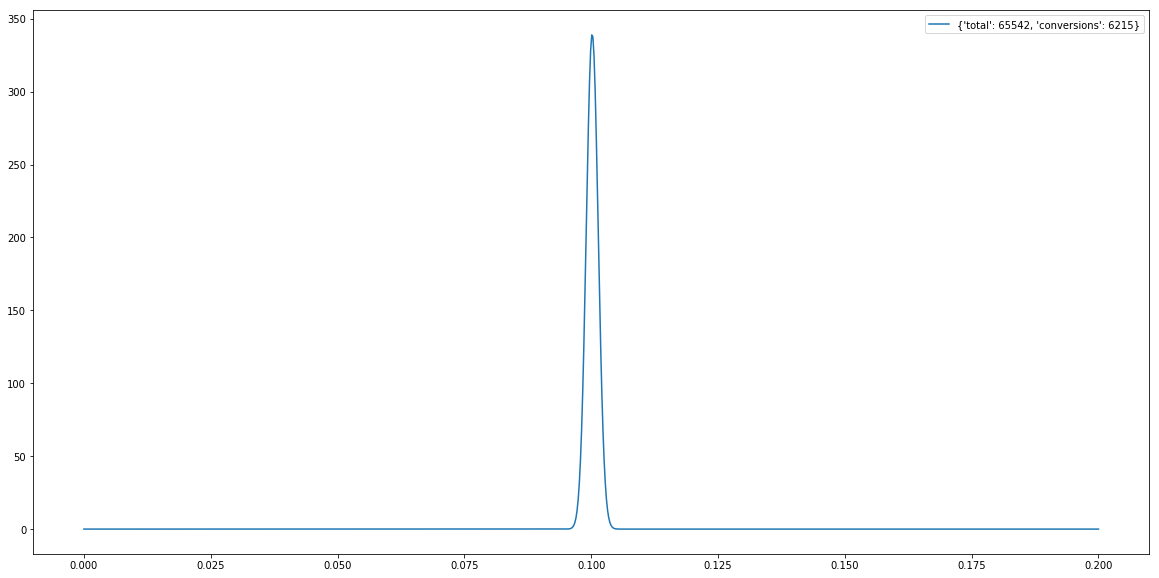

In [83]:
# Suppose we have the results of an A/B test: 
dataA = {
        "total":65410,
        "conversions":6554
}
dataB = {
            "total":65542,
            "conversions":6215
}

# Naively, we might say, well
print ("group A's observed rate: %.3f"%(dataA['conversions']/dataA['total']))
print ("group B's observed rate: %.3f"%(dataB['conversions']/dataB['total']))

# Lets compare the posteriors of these though:

x = np.linspace(0.00,0.2,900)
plot_posteriors(x,dataA,dataB)

In [84]:
samplesA, samplesB = sample_posteriors(dataA,dataB)
(samplesB > samplesA).mean()

0.000551

In [15]:
# So there is a 98% chance that groupB has a larger conversion rate. There is a 1.5% 
# chance we are wrong though. Example is B is in the deep left tail, and A is in the 
# deep right tail. 

## Benefits of this approach over traditional proportional/z-score tests?

1\. I can see the uncertainty in the individual conversion estimates. Suppose we had less data in one group - we should see more uncertainty in this group. This is easy to incorporate. 

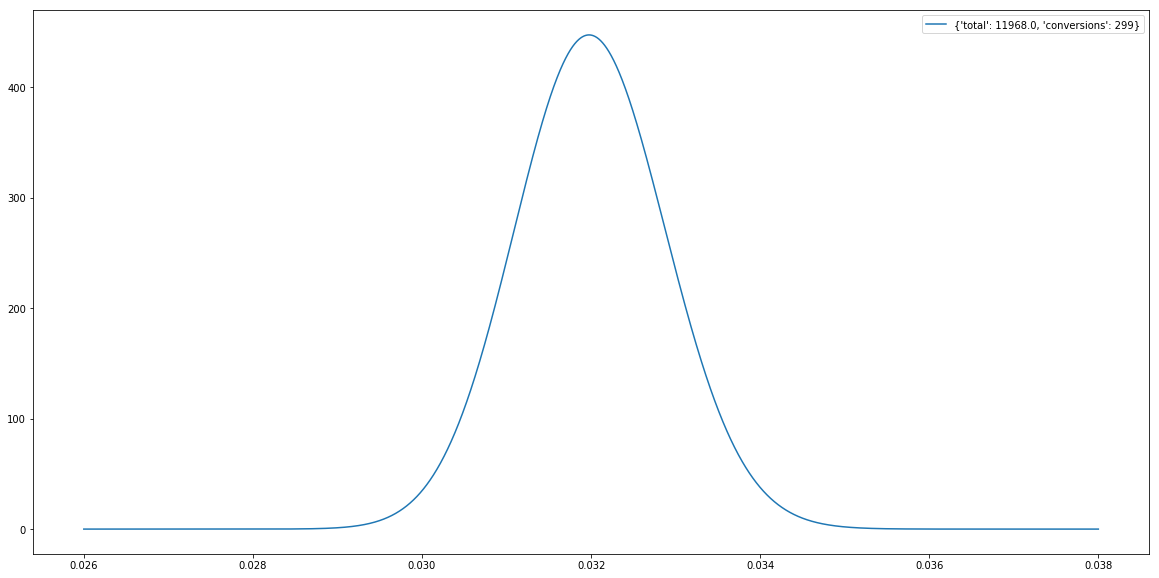

In [71]:
dataA = {
        "total":38904.,
        "conversions":1244
}
dataB = {
            "total":11968.,
            "conversions":299
}
x = np.linspace(0.026,0.038,4000)

plot_posteriors(x, dataA,dataB)

In [29]:
# w.r.t the plot, I have less data for group A, so I can see I have more uncertainty 
# about the true conversion rate. This is less true for group B, where I have lots 
# more data. 

samplesA, samplesB = sample_posteriors(dataA,dataB)
(samplesB > samplesA).mean()

1e-05

2\. I can calculate probabilities of being wrong. This is pretty special: For less risky experiments, I can take more risk, and conclude experiments with less certainty. For very important experiemnts, I can wait until the probability is close to 1.

3\. Knowing which group's conversion rate is larger is only half the experiment's results: we next want to know how *much* large is the conversion rate. Traditional hypothesis testing does not deal with this very well. It would suggest looking at the ratio 

$$\frac{\hat{p_B} - \hat{p_A}}{\hat{p_A}}$$

But this ratio is super unstable and can vary wildly. In our Bayesian framework, we have posterior distributions for $p_A$ and $p_B$, so we can calculate thousands of possible relative increases using samples:

In [85]:
rel_increase = (samplesA - samplesB)/samplesB
print (rel_increase)

[0.02618683 0.03626658 0.07294269 ... 0.05538182 0.07469376 0.05688632]


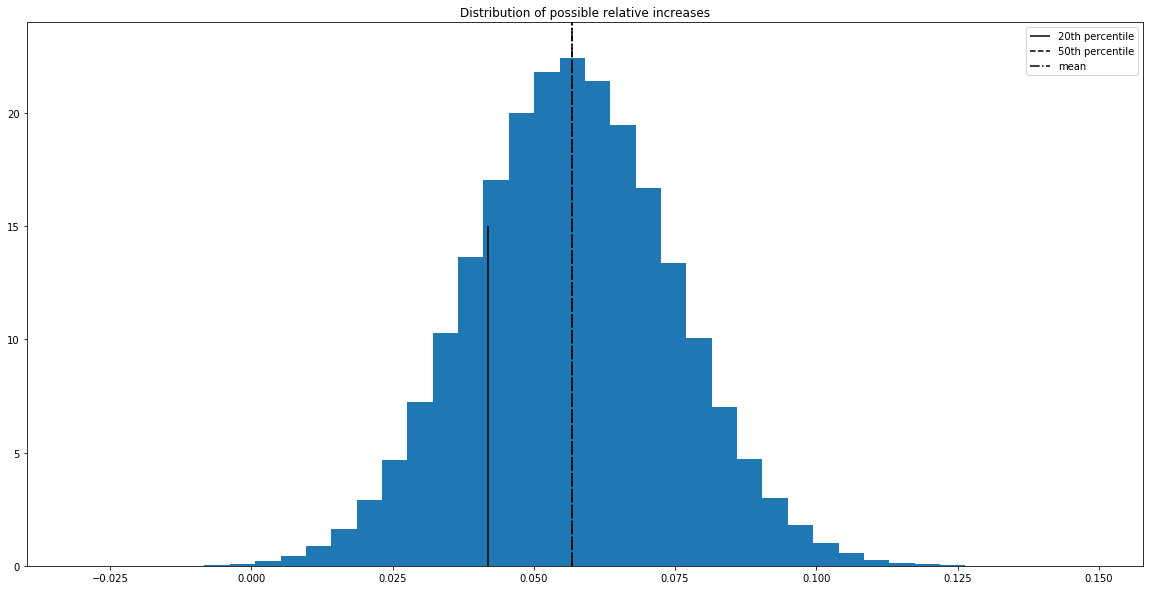

In [89]:
hist(rel_increase, bins = 40, histtype="bar", density=True);
plt.title('Distribution of possible relative increases')
p_30 = np.percentile(rel_increase, 20)
p_50 = np.percentile(rel_increase, 50)
plt.vlines(p_30, 0, 15,label='20th percentile')
plt.vlines(p_50, 0, 24,label='50th percentile', linestyles="--")
plt.vlines(rel_increase.mean(), 0, 24,label='mean', linestyles="-.")

plt.ylim(0,24)
plt.legend()

In [98]:

(rel_increase > 0.02).mean() ## probability the relative increase is more than 3%

0.981966

In [97]:
(rel_increase > 0.05).mean() ## probability the relative increase is more than 10%

0.647092

In [91]:
p_A = dataA['conversions']*1.0/dataA['total']
p_B = dataB['conversions']*1.0/dataB['total']

In [92]:
(p_A - p_B)/p_B

0.056673569512584905